# Predicción Dólar Paralelo Bolivia - Regresión Lineal

Predicción del valor del dólar paralelo usando regresión lineal con datos históricos.

## 1. Librerías

In [23]:
#%pip install pandas numpy matplotlib 
#%pip install openpyxl 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Cargar Datos

In [25]:
# Cargar datos desde Excel
try:
    # Leer archivo Excel
    df_raw = pd.read_excel('dolar_paralelo.xlsx', header=None)
    
    # Asignar nombres a las columnas
    df_raw.columns = ['fecha', 'hora', 'valor1', 'valor2', 'valor3', 'valor4']
    
    print(f"Datos cargados desde Excel: {len(df_raw)} registros")
    print("Estructura de datos:")
    print(df_raw.head())
    print(f"Columnas: {list(df_raw.columns)}")
    
except FileNotFoundError:
    print("Archivo 'dolar_paralelo.xlsx' no encontrado")
    print("Asegúrate de que el archivo esté en el directorio correcto")
except Exception as e:
    print(f"Error al cargar archivo: {e}")

Datos cargados desde Excel: 38876 registros
Estructura de datos:
                 fecha      hora  valor1  valor2  valor3  valor4
0                  NaN       NaN     NaN     NaN     NaN     NaN
1  2024-07-21 00:00:00  17:36:42    6.86    6.96   10.13   10.17
2  2024-07-21 00:00:00  17:44:16    6.86    6.96   10.13   10.17
3  2024-07-21 00:00:00  17:59:16    6.86    6.96   10.14   10.17
4  2024-07-21 00:00:00  18:14:15    6.86    6.96   10.14   10.17
Columnas: ['fecha', 'hora', 'valor1', 'valor2', 'valor3', 'valor4']


In [26]:
# Procesar datos del Excel
def clean_value(value):
    if pd.isna(value) or value == '': 
        return np.nan
    try: 
        # Convertir comas decimales a puntos
        return float(str(value).replace(',', '.'))
    except: 
        return np.nan

def combine_datetime(fecha, hora):
    try:
        # Combinar fecha y hora
        if pd.isna(fecha) or pd.isna(hora):
            return pd.NaT
        
        # Convertir fecha y hora a strings si no lo son
        fecha_str = str(fecha)
        hora_str = str(hora)
        
        # Si fecha ya tiene formato datetime, extraer solo la fecha
        if isinstance(fecha, pd.Timestamp):
            fecha_str = fecha.strftime('%d/%m/%Y')
        elif '/' not in fecha_str:
            # Si no tiene barras, podría ser formato datetime de Excel
            fecha_dt = pd.to_datetime(fecha, errors='coerce')
            if not pd.isna(fecha_dt):
                fecha_str = fecha_dt.strftime('%d/%m/%Y')
        
        # Combinar fecha y hora
        datetime_str = f"{fecha_str} {hora_str}"
        
        # Intentar diferentes formatos
        for fmt in ['%d/%m/%Y %H:%M:%S', '%d/%m/%Y %H:%M', '%Y-%m-%d %H:%M:%S']:
            try:
                return pd.to_datetime(datetime_str, format=fmt)
            except:
                continue
        
        # Si no funciona, intentar parseo automático
        return pd.to_datetime(datetime_str, errors='coerce')
    except:
        return pd.NaT

# Combinar fecha y hora
df_raw['fecha_hora'] = df_raw.apply(lambda row: combine_datetime(row['fecha'], row['hora']), axis=1)

# Limpiar valores numéricos
for col in ['valor1', 'valor2', 'valor3', 'valor4']:
    df_raw[f'{col}_clean'] = df_raw[col].apply(clean_value)

# Crear DataFrame final
df = df_raw[['fecha_hora', 'valor1_clean', 'valor2_clean', 'valor3_clean', 'valor4_clean']].copy()
df.columns = ['fecha', 'valor1', 'valor2', 'valor3', 'valor4']

# Filtrar datos válidos
df = df.dropna(subset=['fecha', 'valor3']).sort_values('fecha').reset_index(drop=True)

print(f"Datos procesados: {len(df)} registros")
if len(df) > 0:
    print(f"Período: {df['fecha'].min().strftime('%d/%m/%Y')} - {df['fecha'].max().strftime('%d/%m/%Y')}")
    print(f"Rango valor3: {df['valor3'].min():.2f} - {df['valor3'].max():.2f}")
    print("\nPrimeros registros:")
    print(df.head())

Datos procesados: 38874 registros
Período: 21/07/2024 - 03/08/2025
Rango valor3: 10.00 - 18.90

Primeros registros:
                fecha  valor1  valor2  valor3  valor4
0 2024-07-21 17:36:42    6.86    6.96   10.13   10.17
1 2024-07-21 17:44:16    6.86    6.96   10.13   10.17
2 2024-07-21 17:59:16    6.86    6.96   10.14   10.17
3 2024-07-21 18:14:15    6.86    6.96   10.14   10.17
4 2024-07-21 18:29:15    6.86    6.96   10.13   10.18


## 3. Preparar Datos

Usando solo los últimos 365 días para mayor precisión
Dataset: 365 registros
Período utilizado: 31/07/2025 - 03/08/2025
Rango valores: 13.70 - 14.00 Bs


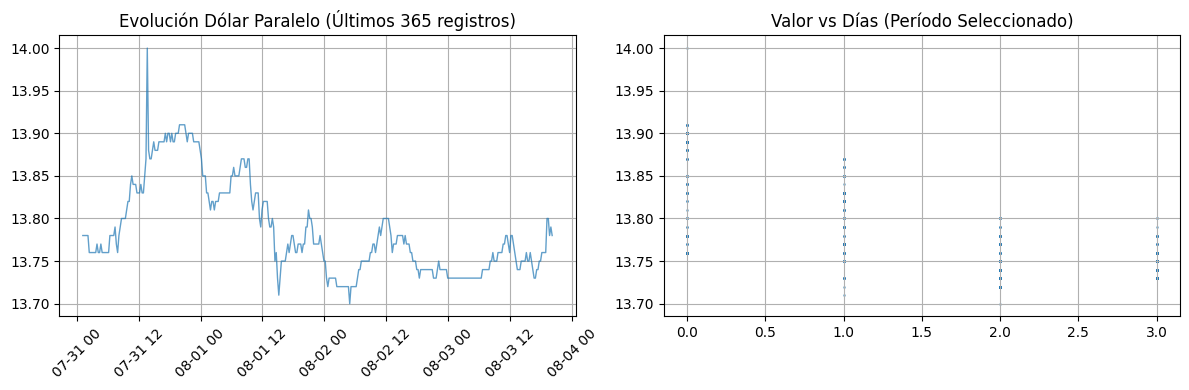

In [27]:
# CONFIGURACIÓN: Ajusta estos valores según necesites
DIAS_RECIENTES =   365# Usar solo los últimos X días para el modelo
USAR_SOLO_RECIENTES = True  # True = solo datos recientes, False = todos los datos

target_column = 'valor3'
df_model = df[['fecha', target_column]].copy().dropna()

# Filtrar solo datos recientes si está habilitado
if USAR_SOLO_RECIENTES and len(df_model) > DIAS_RECIENTES:
    df_model = df_model.tail(DIAS_RECIENTES).reset_index(drop=True)
    print(f"Usando solo los últimos {DIAS_RECIENTES} días para mayor precisión")

fecha_inicio = df_model['fecha'].min()
df_model['dias_desde_inicio'] = (df_model['fecha'] - fecha_inicio).dt.days

print(f"Dataset: {len(df_model)} registros")
print(f"Período utilizado: {df_model['fecha'].min().strftime('%d/%m/%Y')} - {df_model['fecha'].max().strftime('%d/%m/%Y')}")
print(f"Rango valores: {df_model[target_column].min():.2f} - {df_model[target_column].max():.2f} Bs")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(df_model['fecha'], df_model[target_column], alpha=0.7, linewidth=1)
plt.title(f'Evolución Dólar Paralelo (Últimos {len(df_model)} registros)')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_model['dias_desde_inicio'], df_model[target_column], alpha=0.5, s=1)
plt.title('Valor vs Días (Período Seleccionado)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Regresión lineal manual
x = df_model['dias_desde_inicio'].values
y = df_model[target_column].values
n = len(x)

# Dividir datos (80% entrenamiento, 20% prueba)
split_idx = int(0.8 * n)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Calcular pendiente (m) e intercepto (b)
n_train = len(x_train)
sum_x = np.sum(x_train)
sum_y = np.sum(y_train)
sum_xy = np.sum(x_train * y_train)
sum_x2 = np.sum(x_train ** 2)

denominador = (n_train * sum_x2 - sum_x ** 2)
if denominador == 0:
    m = 0
    b = np.mean(y_train)
else:
    m = (n_train * sum_xy - sum_x * sum_y) / denominador
    b = (sum_y - m * sum_x) / n_train

# Predicciones de prueba
y_pred = m * x_test + b
dias_totales = df_model['dias_desde_inicio'].max()

# Calcular R²
if len(y_test) > 0:
    ss_res = np.sum((y_test - y_pred) ** 2)
    ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
else:
    r2 = 0

print(f"Ecuación: Valor = {b:.4f} + {m:.6f} * días")
print(f"R²: {r2:.4f}")
print(f"Datos usados: {n} registros")

Ecuación: Valor = 13.8412 + -0.044707 * días
R²: -5.6140
Datos usados: 365 registros


## 5. Función Predicción

In [29]:
def predecir_dolar(dias_futuros):
    fecha_futura = df_model['fecha'].max() + timedelta(days=dias_futuros)
    dias_desde_inicio_futuro = dias_totales + dias_futuros
    valor_predicho = m * dias_desde_inicio_futuro + b
    ultimo_valor = df_model[target_column].iloc[-1]
    cambio = valor_predicho - ultimo_valor
    
    print(f"Predicción para {dias_futuros} días ({fecha_futura.strftime('%d/%m/%Y')}):")
    print(f"Valor predicho: {valor_predicho:.2f} Bs")
    print(f"Cambio: {cambio:+.2f} Bs ({(cambio/ultimo_valor)*100:+.2f}%)")
    return valor_predicho

# Ejemplos
for dias in [1, 7, 30, 90]:
    predecir_dolar(dias)
    print("-" * 30)

Predicción para 1 días (04/08/2025):
Valor predicho: 13.66 Bs
Cambio: -0.12 Bs (-0.85%)
------------------------------
Predicción para 7 días (10/08/2025):
Valor predicho: 13.39 Bs
Cambio: -0.39 Bs (-2.80%)
------------------------------
Predicción para 30 días (02/09/2025):
Valor predicho: 12.37 Bs
Cambio: -1.41 Bs (-10.26%)
------------------------------
Predicción para 90 días (01/11/2025):
Valor predicho: 9.68 Bs
Cambio: -4.10 Bs (-29.73%)
------------------------------


In [30]:
# Predicción específica (cambiar el número de días)
dias_a_predecir = 5
predecir_dolar(dias_a_predecir)

# Para predicción interactiva, descomenta:
# while True:
#     try:
#         dias = input("Días futuros (o 'quit'): ")
#         if dias.lower() == 'quit': break
#         predecir_dolar(int(dias))
#     except: print("Número inválido")

Predicción para 5 días (08/08/2025):
Valor predicho: 13.48 Bs
Cambio: -0.30 Bs (-2.15%)


np.float64(13.483553542009863)

## 6. Visualización

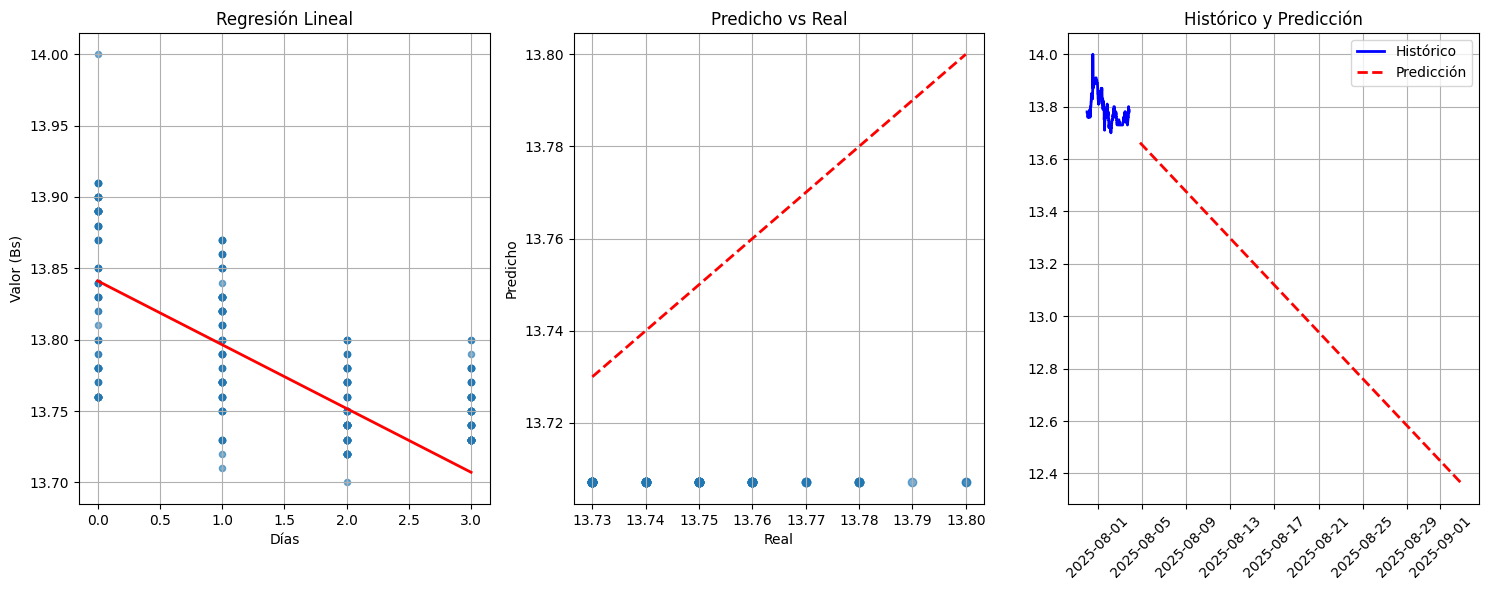

Configuración: 365 registros de últimos 365 días


In [31]:
plt.figure(figsize=(15, 6))

# Regresión
plt.subplot(1, 3, 1)
plt.scatter(df_model['dias_desde_inicio'], df_model[target_column], alpha=0.6, s=20)
X_line = np.linspace(df_model['dias_desde_inicio'].min(), df_model['dias_desde_inicio'].max(), 100)
y_line = m * X_line + b
plt.plot(X_line, y_line, 'r-', linewidth=2)
plt.xlabel('Días')
plt.ylabel('Valor (Bs)')
plt.title('Regresión Lineal')
plt.grid(True)

# Predicho vs Real
plt.subplot(1, 3, 2)
if len(y_test) > 0:
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Real')
    plt.ylabel('Predicho')
    plt.title('Predicho vs Real')
    plt.grid(True)

# Predicciones futuras
plt.subplot(1, 3, 3)
plt.plot(df_model['fecha'], df_model[target_column], 'b-', label='Histórico', linewidth=2)
dias_fut = range(1, 31)
fechas_fut = [df_model['fecha'].max() + timedelta(days=d) for d in dias_fut]
valores_fut = [m * (dias_totales + d) + b for d in dias_fut]
plt.plot(fechas_fut, valores_fut, 'r--', label='Predicción', linewidth=2)
plt.title('Histórico y Predicción')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Configuración: {len(df_model)} registros de últimos {DIAS_RECIENTES} días")

## 7. Evaluación

In [32]:
# Evaluación del modelo
if len(y_test) > 0:
    mae = np.mean(np.abs(y_test - y_pred))
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    print(f"R²: {r2:.4f} ({r2*100:.1f}% varianza explicada)")
    print(f"Error promedio: ±{mae:.2f} Bs")
    print(f"RMSE: ±{rmse:.2f} Bs")

tendencia = "CRECIENTE" if m > 0 else "DECRECIENTE" if m < 0 else "ESTABLE"
print(f"Tendencia: {tendencia} ({abs(m):.4f} Bs/día)")
print(f"Cambio mensual: {abs(m) * 30:.2f} Bs/mes")
print(f"Ecuación: Valor = {b:.4f} + {m:.6f} * días")

R²: -5.6140 (-561.4% varianza explicada)
Error promedio: ±0.04 Bs
RMSE: ±0.05 Bs
Tendencia: DECRECIENTE (0.0447 Bs/día)
Cambio mensual: 1.34 Bs/mes
Ecuación: Valor = 13.8412 + -0.044707 * días
